In [1]:
!rm -rf FML
!git clone https://github.com/svenspa/FML.git

Cloning into 'FML'...
remote: Enumerating objects: 396, done.
remote: Counting objects: 100% (396/396), done.
remote: Compressing objects: 100% (290/290), done.
remote: Total 396 (delta 168), reused 288 (delta 96), pack-reused 0
Receiving objects: 100% (396/396), 805.63 KiB | 19.18 MiB/s, done.
Resolving deltas: 100% (168/168), done.


In [2]:
import sys
sys.path.append("FML")

In [43]:
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter
from risk_measures import expected_shortfall

from market_dynamics import bs_delta, bs_generator, bs_call_price
from data import SimulationData
from utils import call_payoff, stochastic_integral
from models import ControlNet
from train import train, test
from evaluation import get_eval_data

import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
device = torch.device('cpu')

In [45]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [46]:
worst_option = pd.read_csv("data/121415366.csv", index_col=0)
best_option = pd.read_csv("data/110253979.csv", index_col=0)
option_ids = ["121415366", "110253979"]
option_dfs = [worst_option, best_option]

In [47]:
# Hyperparameters to choose from

e = [5, 10, 15]
e2 = [1, 2, 4, 5]
lr = np.logspace(0.001, 0.01, num=4)
bs = [100, 250, 500, 1000, 2000]
ndims = [2, 3, 5]
fcdims = [16, 32, 64]

In [48]:
def es_criterion(input, target):
    return expected_shortfall(input - target)

In [49]:
for _ in range(1):

  # Chosing parameters
  ndim = int(np.random.choice(ndims))
  fcdim = int(np.random.choice(fcdims))

  h_params = {"N_SIM": 15_000,
              "RF": 0,
              "N_DIMS": 3,
              "FC_DIM": 32,
              "LR": 0.005,
              "GAMMA": 0.99,
              "EPOCHS": 10,
              "EPOCHS_2": 2, 
              "BATCH_SIZE": 250,}

  for option_id, option_df in zip(option_ids, option_dfs):

      current_time = datetime.now().strftime('%b%d_%H-%M-%S')
      comment = option_id
      log_dir = os.path.join('experiments', current_time + '_' + comment)
      writer = SummaryWriter(log_dir)

      # Get params dependent on data
      strike, sigma, n_steps, initial_value, x, x_inc, payoff, price = get_eval_data(option_df)
      x, x_inc = x.to(device), x_inc.to(device)

      # Using implied volatility should give back market price 
      price, bs_call_price(n_steps, initial_value, sigma, h_params["RF"], strike)


      bs_params = {"n_simulations": h_params["N_SIM"],
                  "n_steps": n_steps,
                  "initial_value": initial_value,
                  "sigma": sigma,
                  }

      price_params = {"n_steps": n_steps,
                      "initial_value": initial_value,
                      "sigma": sigma,
                      "rf": h_params["RF"],
                      "strike": strike,
                      }

      payoff_params = {"strike": strike}

      cn = ControlNet(n_steps, 1, h_params['N_DIMS'] * [h_params["FC_DIM"]], 1, learn_price=False)
      cn.to(device)
      cn.bn_to(device)

      optimizer = Adam(cn.parameters(), lr=h_params["LR"])
      scheduler = ExponentialLR(optimizer, gamma=h_params["GAMMA"])

      for i in range(h_params["EPOCHS_2"]):
        dt = SimulationData(bs_generator, bs_params, lambda x: x, {"x": price}, call_payoff, payoff_params)
        data_loader_train = DataLoader(dt, batch_size=h_params["BATCH_SIZE"], shuffle=True, pin_memory=True)
        train(data_loader_train, cn, es_criterion , optimizer, h_params["EPOCHS"], writer, scheduler, device=device, metric=torch.nn.MSELoss())

      # Model
      cn.eval_mode()

      hedge = cn(x)
      si = stochastic_integral(x_inc, hedge)

      ml_mkt_price = (price + si - payoff) ** 2
      #ml_learned_price = (learned_price + si - payoff) ** 2

      # Delta hedge benchmark
      def delta(x):
          return bs_delta(n_steps, x, sigma, h_params["RF"], strike)

      d_hedge = torch.Tensor([delta(i) for i in x.squeeze().detach().cpu().numpy()])
      si = stochastic_integral(x_inc.cpu(), d_hedge)
      dl_mkt_price = (price + si - payoff) ** 2
      #dl_learned_price = (learned_price + si - payoff) ** 2

      metrics = {"price": price,
                "bs_price": bs_call_price(n_steps, initial_value, sigma, h_params["RF"], strike),
                "learned_price": learned_price.detach().item(),
                "ml_mkt_price": ml_mkt_price.detach().item(),
                "ml_learned_price": ml_learned_price.detach().item(),
                "dl_mkt_price": dl_mkt_price.detach().item(),
                "dl_learned_price": dl_learned_price.detach().item(),
                }

      writer.add_hparams(h_params, metrics)

      for s, m, d in zip(option_df.S.values, hedge[0].detach().tolist(), d_hedge.detach().tolist()):
        writer.add_scalars('hedge', {"S": s,
                                    "model_hedge": m,
                                    "delta_hedge": d})

Epoch 0: : 60batch [00:24,  2.44batch/s, loss=9.45, metric=125]
Epoch 1: : 60batch [00:23,  2.50batch/s, loss=8.26, metric=60.6]
Epoch 2: : 60batch [00:22,  2.67batch/s, loss=7.24, metric=70.4]
Epoch 3: : 60batch [00:21,  2.75batch/s, loss=5.73, metric=44.7]
Epoch 4: : 60batch [00:21,  2.82batch/s, loss=7.74, metric=67.6]
Epoch 5: : 60batch [00:21,  2.83batch/s, loss=6.94, metric=53]
Epoch 6: : 60batch [00:25,  2.39batch/s, loss=7.58, metric=55.9]
Epoch 7: : 60batch [00:22,  2.66batch/s, loss=6.4, metric=52.2]
Epoch 8: : 60batch [00:22,  2.67batch/s, loss=5.81, metric=39.2]
Epoch 9: : 60batch [00:27,  2.16batch/s, loss=7.44, metric=61.8]
Epoch 0: : 60batch [00:28,  2.08batch/s, loss=6.26, metric=38.1]
Epoch 1: : 60batch [00:28,  2.11batch/s, loss=6.35, metric=41.2]
Epoch 2: : 60batch [00:23,  2.53batch/s, loss=5.98, metric=40.2]
Epoch 3: : 60batch [00:21,  2.76batch/s, loss=6.65, metric=42.1]
Epoch 4: : 60batch [00:21,  2.80batch/s, loss=5.17, metric=34.2]
Epoch 5: : 60batch [00:20,  2

<AxesSubplot:>

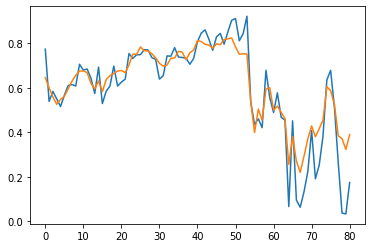

In [28]:
pd.Series(hedge.squeeze().detach().numpy()).plot()
pd.Series(d_hedge.squeeze().detach().numpy()).plot()

In [ ]:
!tensorboard dev upload --logdir ./experiments \
  --name "Model risk in deep hedging" \
  --description "FML project" \
  --one_shot

2021-11-30 15:52:15.393380: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./experiments

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg